In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [2]:
# Load the data
df = pd.read_csv('../Data/adult_cleaned.csv')
df.head()

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
# label encoding

le = LabelEncoder()

categorical_columns = df.select_dtypes(include=['object']).columns

for col in categorical_columns:
    df[col] = le.fit_transform(df[col])
    # print the class name and the label for each column as a dataframe
    print(pd.DataFrame({col: le.classes_, 'label': le.transform(le.classes_)}))
    print()

          workclass  label
0       Federal-gov      0
1         Local-gov      1
2           Private      2
3      Self-emp-inc      3
4  Self-emp-not-inc      4
5         State-gov      5
6       Without-pay      6

       education  label
0           10th      0
1           11th      1
2           12th      2
3        1st-4th      3
4        5th-6th      4
5        7th-8th      5
6            9th      6
7     Assoc-acdm      7
8      Assoc-voc      8
9      Bachelors      9
10     Doctorate     10
11       HS-grad     11
12       Masters     12
13     Preschool     13
14   Prof-school     14
15  Some-college     15

          marital-status  label
0               Divorced      0
1      Married-AF-spouse      1
2     Married-civ-spouse      2
3  Married-spouse-absent      3
4          Never-married      4
5              Separated      5
6                Widowed      6

           occupation  label
0        Adm-clerical      0
1        Armed-Forces      1
2        Craft-repair      2
3

In [4]:
df.head()

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,5,77516,9,4,0,1,4,1,2174,0,40,38,0
1,50,4,83311,9,2,3,0,4,1,0,0,13,38,0
2,38,2,215646,11,0,5,1,4,1,0,0,40,38,0
3,53,2,234721,1,2,5,0,2,1,0,0,40,38,0
4,28,2,338409,9,2,9,5,2,0,0,0,40,4,0


In [5]:
# Split to X and y
X = df.drop(columns=['income'])
y = df['income']

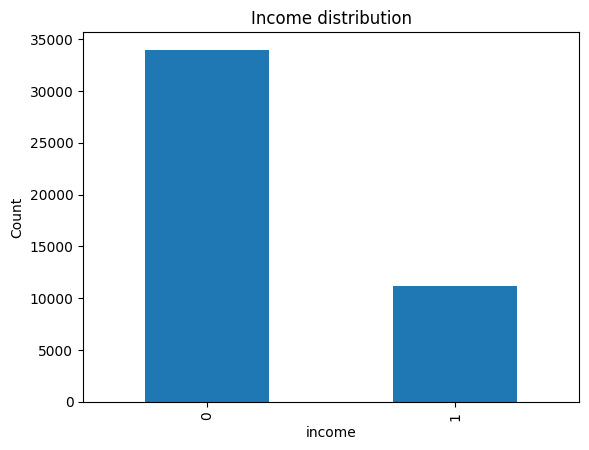

In [6]:
y.value_counts().plot(kind='bar')
plt.title('Income distribution')
plt.ylabel('Count')
plt.show()

In [7]:
# Scale the data
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [8]:
# Split to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
X_train.shape, X_test.shape

((36140, 13), (9035, 13))

In [10]:
y_train.value_counts()

income
0    27143
1     8997
Name: count, dtype: int64

In [11]:
model = GaussianNB()

# Grid search
param_grid = {
    'var_smoothing': np.logspace(0, -9, num=1000)
}

grid_search = GridSearchCV(model, param_grid, cv=10, verbose=1, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy score found: ", grid_search.best_score_)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


Best parameters found:  {'var_smoothing': 0.044529585099426554}
Best accuracy score found:  0.797371333702269


In [12]:
best_model = grid_search.best_estimator_
best_model

GaussianNB(var_smoothing=0.044529585099426554)

In [13]:
# Predict testing data
y_pred = best_model.predict(X_test)

# Predict Train data
y_pred_train = best_model.predict(X_train)
print()

# Evaluate the model
print(classification_report(y_test, y_pred))
print(f'Testing Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Training Accuracy: {accuracy_score(y_train, y_pred_train)}')



              precision    recall  f1-score   support

           0       0.81      0.96      0.88      6830
           1       0.72      0.30      0.42      2205

    accuracy                           0.80      9035
   macro avg       0.77      0.63      0.65      9035
weighted avg       0.79      0.80      0.77      9035

Testing Accuracy: 0.8003320420586607
Training Accuracy: 0.7975373547315994


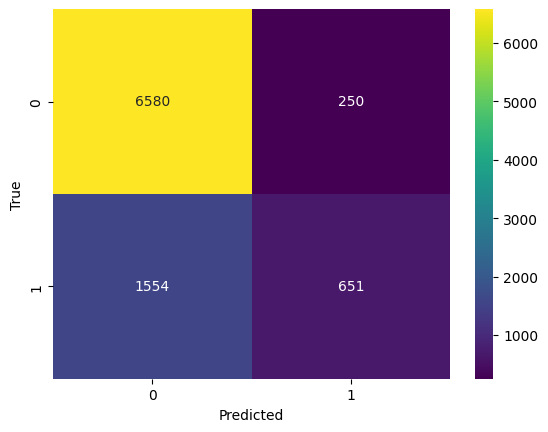

In [14]:
# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='viridis', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

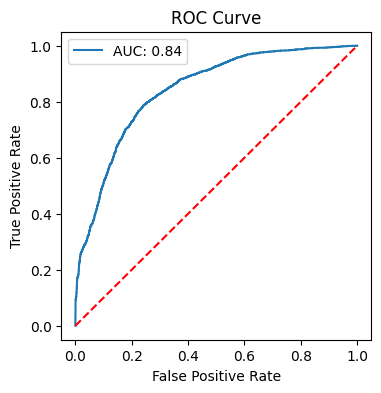

In [15]:
# get the probability of the positive class (>50k)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# get the roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# plot the roc curve
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label=f'AUC: {roc_auc_score(y_test, y_pred_proba):.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()